In [1]:
from __future__ import division
from utils import *
import array 

from pydub import AudioSegment
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical



from tqdm import tqdm_notebook
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

from keras.callbacks import TensorBoard



%matplotlib inline

Using TensorFlow backend.


In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

#### load raw auidos into memory for faster processing

In [3]:
%%time 

train_df = pickle.load( open("cache/train_df_waug.pik","rb"))
valid_df = pickle.load( open("cache/valid_df.pik","rb"))
silent_df = pickle.load(open("cache/silent_df.pik","rb"))
unknown_df = pickle.load(open("cache/unknown_df_waug.pik","rb"))
test_df =  pickle.load(open("cache/test_df.pik","rb"))

CPU times: user 18 s, sys: 12.6 s, total: 30.6 s
Wall time: 30.6 s


### generators
train gen will also sample from test files

In [368]:
(train_df.shape[0] + unknown_df.shape[0] + test_df.shape[0])/64

3382.203125

In [4]:
# there are a couple of records with all 'pixel' values set to 1.0, they will cause 'inf' loss durin training, so removing them
means = test_df.raw.apply(lambda x: x[0].mean() ) 
test_df = test_df[  means < 0.0]

In [8]:
def train_generator(train_batch_size):
    while True:
        
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))
        extra_data_size = int(this_train.shape[0]* 0.1)
        this_train = pd.concat([test_df , #.sample(this_train.shape[0]),
                                silent_df.sample(extra_data_size),
                                this_train,
                                unknown_df.sample(n = unknown_df.shape[0]//5)],axis=0 ) #.sample(this_train.shape[0])],axis=0)
        
        this_train.reset_index(drop=True,inplace=True)
#         print this_train.columns
        
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
                x_batch.append(this_train.loc[i,'raw'].T)
                
            x_batch = 1.- np.array(x_batch)/-80.
#             y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, x_batch

In [9]:
train_df.shape

(105525, 6)

In [11]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(valid_df.loc[i,'raw'].T)

            x_batch = 1.- np.array(x_batch)/-80.
            yield x_batch, x_batch

In [192]:
next(valid_generator(64))[0].mean()

0.31318883826536237

In [8]:
#a common practice is to choose a filter size in time which spans 2/3 o

In [15]:
from keras.layers import Input, GRU, RepeatVector, BatchNormalization, TimeDistributed, Conv1D
from keras import backend as K
from keras.layers import  Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape


timesteps, input_dim , latent_dim = 32,128, 128

# inputs = Input(shape=(timesteps, input_dim))
# conv2d = Conv1D(64,1,activation='relu')(inputs)
# encoded = GRU(latent_dim,return_sequences=True)(conv2d)
# encoded = GRU(latent_dim,return_sequences=True)(encoded)
# encoded = TimeDistributed(Dense(latent_dim, activation='sigmoid'))(encoded)

# # decoded = RepeatVector(timesteps)(encoded)
# decoded = GRU(latent_dim, return_sequences=True)(encoded)
# decoded = GRU(latent_dim, return_sequences=True)(decoded)
# decoded = TimeDistributed(Dense(input_dim, activation='sigmoid'))(decoded)

# model = Model(inputs, decoded)

In [24]:
input_img = Input(shape=(timesteps, input_dim))  # adapt this if using `channels_first` image data format

x = Reshape((timesteps, input_dim,1))(input_img)


x = Conv2D(64, (16, 10), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (8, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (4, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(32, (4, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (8, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (16, 10), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoded  = Reshape((timesteps, input_dim))(decoded)

model = Model(input_img, decoded)
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 128)           0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 128, 64)       10304     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 64, 32)        81952     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 32, 32)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 32, 32)         12320     
__________

In [ ]:
#original
# x = Conv2D(64, (10, 10), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x)

# # at this point the representation is (4, 4, 8) i.e. 128-dimensional

# x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(64, (10, 10), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# decoded  = Reshape((timesteps, input_dim))(decoded)


In [26]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [27]:
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=['accuracy'])

In [145]:
# model.load_weights('weights/starter_{}.hdf5'.format(exp_name))
# model.load_weights('weights/starter_ae_lstm_large_withdense_128_with_test.hdf5')
# model.load_weights('weights/starter_ae_wtest_conv_rmse_c5.hdf5'.format(exp_name))
# 

Epoch 8/100
329/329 [==============================] - 30s - loss: 0.5700 - acc: 0.1437 - val_loss: 0.5567 - val_acc: 0.1522

RMSE
latent_dim = 128
Epoch 16/100
329/329 [==============================] - 48s - loss: 0.0966 - acc: 0.2346 - val_loss: 0.0859 - val_acc: 0.2259

latent_dim = 256
Epoch 10/100
329/329 [==============================] - 47s - loss: 0.0946 - acc: 0.2367 - val_loss: 0.0844 - val_acc: 0.2312

latdim: 256, mse
Epoch 11/100
330/329 [==============================] - 50s - loss: 0.0113 - acc: 0.1773 - val_loss: 0.0093 - val_acc: 0.2245

latdim: 256, bxent
330/329 [==============================] - 51s - loss: 0.4866 - acc: 0.1917 - val_loss: 0.5078 - val_acc: 0.1525
Epoch 00011: early stopping


Epoch 00012: reducing learning rate to 0.000999999977648. adadelta bix, conv tiramisu
990/989 [==============================] - 93s - loss: 0.4627 - acc: 0.1618 - val_loss: 0.4635 - val_acc: 0.1526


ae_wtest_conv_rmse_c3, adam, root_mean_squared_error
Epoch 7/100
3300/3300 [==============================] - 388s - loss: 0.1300 - acc: 0.4638 - val_loss: 0.1303 - val_acc: 0.4960

ae_wtest_conv_rmse_c6
Epoch 23/100
3300/3300 [==============================] - 386s - loss: 0.0260 - acc: 0.5283 - val_loss: 0.0263 - val_acc: 0.5537

In [28]:
exp_name = "ae_wtest_conv_rmse_larger_convs"
callbacks = [EarlyStopping(monitor='val_acc',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_acc',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                               min_lr=1e-5),
             
             ModelCheckpoint(monitor='val_acc',
                             filepath='weights/starter_{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True)
             
#             ,TensorBoard(log_dir='./logs/logs_{}'.format(exp_name), histogram_freq=0, batch_size=64, write_graph=True)
            ]

In [29]:
history = model.fit_generator(generator=train_generator(64),
                              steps_per_epoch=3300, #train_df.shape[0]*3/64,
                              epochs=100,
                              callbacks=callbacks,
                              shuffle=True,
                              validation_data=valid_generator(64),
                              validation_steps=int(np.ceil(valid_df.shape[0]/64)))

Epoch 1/100
 662/3300 [=====>........................] - ETA: 442s - loss: 0.0696 - acc: 0.1164

KeyboardInterrupt: 

In [148]:
model.load_weights('weights/starter_{}.hdf5'.format(exp_name))

In [166]:
t = next(valid_generator(64))[0][18].T

#### actual

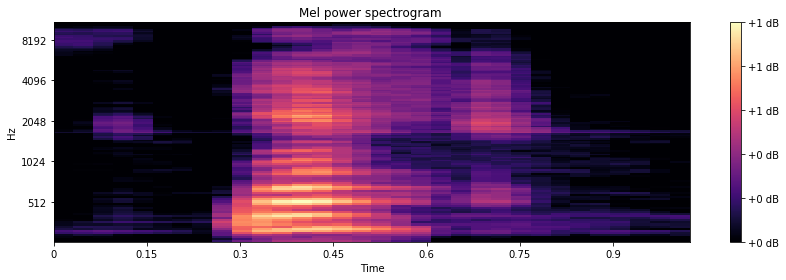

In [167]:
plot_mel(t)

In [168]:
b = model.predict(t.T.reshape(1,t.shape[1],t.shape[0]))[0].T

#### conv2d - mse

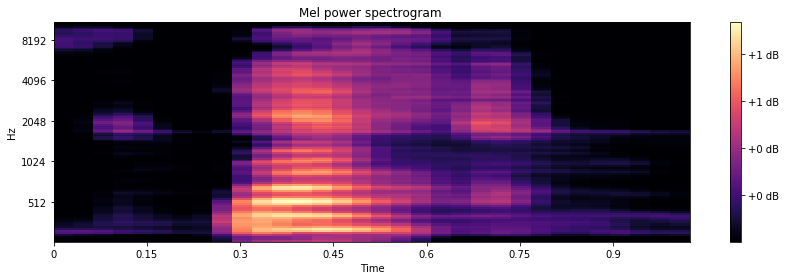

In [169]:
plot_mel(b) #(b-1.)*80

#### conv2d - bix

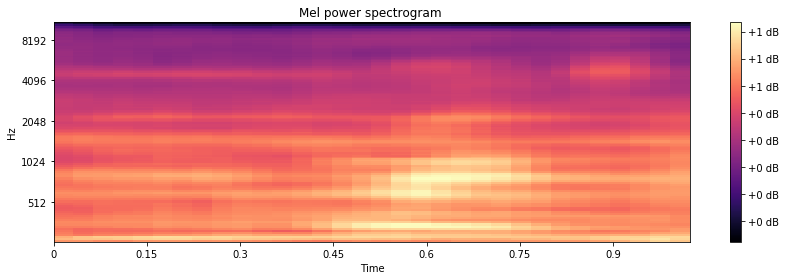

In [331]:
plot_mel(b) #(b-1.)*80

In [293]:
t.shape

(1, 128, 32)

In [139]:
model.load_weights('./weights/starter_pyramid_conv.hdf5')

In [155]:
def test_generator(test_batch_size,augment=False):
    while True:
        for start in range(0, len(test_paths), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(test_paths))
            this_paths = test_paths[start:end]
            for x in this_paths:
                x_batch.append(process_wav_file(x,reshape=True,augment=augment,pval=0.5))
            x_batch = np.array(x_batch)
            yield x_batch

In [143]:
predictions = model.predict_generator(test_generator(64,augment=False), int(np.ceil(len(test_paths)/64.)), verbose=1)

2478/2478 [==============================] - 1230s  


In [152]:
np.save("cache/predictions_pyramid_noaug.npy",predictions)

In [156]:
num_aug = 2 
for i in range(num_aug):
    predictions +=  model.predict_generator(test_generator(64,augment=True), int(np.ceil(len(test_paths)/64.)), verbose=1)
    

2477/2478 [============================>.] - ETA: 0s

In [157]:
predictions = predictions/(num_aug + 1.0)

In [158]:
classes = np.argmax(predictions, axis=1)

In [159]:
# last batch will contain padding, so remove duplicates
submission = dict()
for i in range(len(test_paths)):
    fname, label = os.path.basename(test_paths[i]), id2name[classes[i]]
    submission[fname] = label

In [160]:
with open('subm/starter_submission{}_3xtta.csv'.format(exp_name), 'w') as fout:
    fout.write('fname,label\n')
    for fname, label in submission.items():
        fout.write('{},{}\n'.format(fname, label))